In [1]:
import numpy as np
import matplotlib as plt
import tensorflow as tf
from matplotlib.colors import LogNorm
from functions import*
import math
import os
from scipy.interpolate import griddata
from matplotlib.colors import LogNorm
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [42]:
def inverse_normalize_S(S,S_max,S_min):
    return (S_max-S_min)*S+S_min

def max_min(S):
    ma = np.amax(S)
    mi = -np.amax(-S)
    print(ma,mi)
    return [ma,mi]

def normalize_M(M):
    M_norm = np.zeros((np.shape(M)[0],np.shape(M)[1]))
    M_max = np.amax(M, axis=0)
    M_min = -np.amax(-M,axis=0)
    for i in range(np.shape(M)[0]):
        for j in range(np.shape(M)[1]):
            M_norm[i,j] = (M[i,j]- M_min[j])/(M_max[j]-M_min[j])
    return [M_norm,M_max,M_min]

def normalize_M_test(M,maxi,mini):
    M_norm = np.zeros((np.shape(M)[0],np.shape(M)[1]))
    for i in range(np.shape(M)[0]):
        for j in range(np.shape(M)[1]):
            M_norm[i,j] = (M[i,j]- mini[j])/(maxi[j]-mini[j])
            #print((M[i,j]- mini[i])/(maxi[i]-mini[i]))
    return M_norm

def get_av_max_min_persec(S):
    arr_ma = np.zeros(40)
    arr_mi = np.zeros(40)
    for i in range(40):
        ma = 0
        mi = 0
        for j in range(95):
            ma = max(ma,np.amax(S[i+j*40,:]))
            mi = min(mi,-np.amax(-S[i+j*40,:]))
        arr_ma[i] = ma
        arr_mi[i] = mi
    return arr_ma,arr_mi

def inverse_norm_input_bysec(S,ma,mi):
    x = np.shape(S)[0]
    y = np.shape(S)[1]
    S_norm = np.zeros((x,y))
    for i in range(x):
        S_norm[i,:] = (ma[i%40]-mi[i%40])*S[i,:]+mi[i%40]
    return S_norm
 
    
def get_max_min_feature(S):
    ma = np.amax(S,axis = 0)
    mi = -np.amax(-S,axis = 0)
    return ma,mi

def inv_normalize_s_byfeature(S,ma,mi):
    S_norm = np.zeros((np.shape(S)[0],np.shape(S)[1]))
    for i in range(np.shape(S)[0]):
        for j in range(np.shape(S)[1]):
            S_norm[i,j] = (ma[j]-mi[j])*S[i,j]+mi[j]
            #print((M[i,j]- mini[i])/(maxi[i]-mini[i]))
    return S_norm

def read_files_centers(file_path):
    with open(file_path, 'r') as file:
        if file_path[-1] != 'U':
            lines = np.array(file.read().split("\n"))
            start = np.where(lines == "(")
            end = np.where(lines == ")")
            if len(start[0]) != 0:
                output = np.array(lines[start[0][0]+1:end[0][0]])
                return output
            else:
                return []
        else:
            U = read_U(file_path)
            return U
        
        
def predictions(N,DFNN,Decoder,n_params,S_test,M_test,V,ma,mi):
    x,y = np.shape(S_test)
    S_predicted = np.zeros((x,y))

    for count,i in enumerate(M_test):
        i = np.array(i,dtype=float32)
        DFNN_out = DFNN(tf.reshape(i,[-1,n_params]))
        Dec_out = Decoder(DFNN_out)
        Dec_out = tf.reshape(Dec_out,[-1,N]).numpy()
        Dec_out = inverse_normalize_S(Dec_out,ma,mi)
        if (count-0)%(int(x/5)) == 0:
            plt.imshow(tf.reshape(Dec_out[0],[-1,int(np.sqrt(N)),int(np.sqrt(N)),1])[0].numpy(),interpolation='nearest', aspect='auto')
            plt.colorbar()
            plt.show()
        S_predicted[count,:] = np.matmul(V,Dec_out[0])
    return S_predicted

def predictions_for_time_sep(N,DFNN,Decoder,n_params,S_test,M_test,V1,V2,ma,mi,cut,seconds):
    x,y = np.shape(S_test)
    S_predicted = np.zeros((x,y))

    for count,i in enumerate(M_test):
        i = np.array(i,dtype=float32)
        DFNN_out = DFNN(tf.reshape(i,[-1,n_params]))
        Dec_out = Decoder(DFNN_out)
        Dec_out = tf.reshape(Dec_out,[-1,N]).numpy()
        print(count % seconds)
        if count % seconds < cut:
            
            Dec_out = inverse_normalize_S(Dec_out,2691.31267152273,-541.5646086547722)
        else:
            Dec_out = inverse_normalize_S(Dec_out,70702.11612135358,-11528.10604925989)
        if (count-0)%(int(x/5)) == 0:
            plt.imshow(tf.reshape(Dec_out[0],[-1,int(np.sqrt(N)),int(np.sqrt(N)),1])[0].numpy(),interpolation='nearest', aspect='auto')
            plt.colorbar()
            plt.show()
        if count % seconds  < cut:
            S_predicted[count,:] = np.matmul(V1,Dec_out[0])
        else:
            S_predicted[count,:] = np.matmul(V2,Dec_out[0])
    return S_predicted


def predictions_fromvel(N,DFNN,Decoder,n_params,S_test,M_test,V,ma,mi,dt=1):
    x,y = np.shape(M_test)
    S_predicted = np.zeros((x,y))
    S_true = np.zeros((x,y))

    for count,i in enumerate(M_test):
        i = np.array(i,dtype=float32)
        DFNN_out = DFNN(tf.reshape(i,[-1,n_params]))
        Dec_out = Decoder(DFNN_out)
        Dec_out = tf.reshape(Dec_out,[-1,N]).numpy()
        Dec_out = inverse_normalize_S(Dec_out,ma,mi)
        if (count-6)%(40) == 0:
            plt.plot(Dec_out[0])
            plt.show()
        S_predicted[count,:] = np.matmul(V,Dec_out[0])

    for count,i in enumerate(S_predicted):
        if count%40 == 0:
            S_true[count,:] = i
        else:
            S_true[count,:] = dt*i+S_true[count-1,:]
    
    return S_true

def predictions_norm_by_snap(N,DFNN,Decoder,n_params,S_test,M_test,V,ma,mi):
    prediction_before_norm = np.zeros((200,256))
    S_predicted = np.zeros((200,68650))

    for count,i in enumerate(M_test):
        i = np.array(i,dtype=float32)
        DFNN_out = DFNN(tf.reshape(i,[-1,n_params]))
        Dec_out = Decoder(DFNN_out)
        Dec_out = tf.reshape(Dec_out,[-1,N]).numpy()
        prediction_before_norm[count,:] =  Dec_out[0]
        
    S_int = inverse_norm_input_bysec(prediction_before_norm,ma,mi)
    for count,i in enumerate(S_int):
        if (count-0)%(40) == 0:
            plt.plot(prediction_before_norm[count,:])
            plt.show()
        S_predicted[count,:] = np.matmul(V,i)
    return S_predicted

def predictions_norm_by_feat(N,DFNN,Decoder,n_params,S_test,M_test,V,ma,mi):
    prediction_before_norm = np.zeros((200,256))
    S_predicted = np.zeros((200,68650))

    for count,i in enumerate(M_test):
        i = np.array(i,dtype=float32)
        DFNN_out = DFNN(tf.reshape(i,[-1,n_params]))
        Dec_out = Decoder(DFNN_out)
        Dec_out = tf.reshape(Dec_out,[-1,N]).numpy()
        prediction_before_norm[count,:] =  Dec_out[0]
        
    S_int = inv_normalize_s_byfeature(prediction_before_norm,ma,mi)
    for count,i in enumerate(S_int):
        if (count-0)%(40) == 0:
            plt.plot(i)
            plt.show()
        S_predicted[count,:] = np.matmul(V,i)
    return S_predicted


def plots_in_time(S_test,S_predicted,cell_true,path,seconds,secondstoplot):
    fig,ax = plt.subplots(len(secondstoplot),3,figsize = (20,len(secondstoplot)*5))
    for u,i in enumerate(secondstoplot):
        count = i-2+0
        cm = plt.cm.get_cmap('RdYlBu_r')
        #ax = fig.gca(projection='3d')
        scatter_plot = ax[u][0].scatter(cell_true[:,0], cell_true[:,1], c = S_predicted[count,:], s=0.5,cmap=cm)
        ax[u][0].set_title('Predicted t = '+str(i))
        plt.colorbar(scatter_plot, ax=ax[u,0])
        scatter_plot = ax[u][1].scatter(cell_true[:,0], cell_true[:,1], c = S_test[count,:], s=0.5,cmap=cm)
        ax[u][1].set_title('FOM')
        plt.colorbar(scatter_plot, ax=ax[u,1])
        scatter_plot = ax[u][2].scatter(cell_true[:,0], cell_true[:,1], c = np.abs(S_test[count,:]-S_predicted[count,:])/np.sqrt(1/seconds*np.sum(np.linalg.norm(S_test[0:seconds],axis=1)**2)), s=0.5,cmap=cm)
        ax[u][2].set_title('Relative error')
        plt.colorbar(scatter_plot, ax=ax[u,2])
    plt.savefig(path+'/vWFs_with_'+str(secondstoplot)+'_second_t_final_.png',dpi=150,facecolor='w',transparent=True,bbox_inches='tight')
    plt.show()
    return 0

def plots_in_sim(S_test,S_predicted,cell_true,path,t,seconds):
    fig,ax = plt.subplots(5,3,figsize = (20,20))
    for i in range(5):
        cm = plt.cm.get_cmap('RdYlBu_r')
        #ax = fig.gca(projection='3d')
        scatter_plot = ax[i][0].scatter(cell_true[:,0], cell_true[:,1], c = S_predicted[(t-2)+i*seconds,:], s=0.5,cmap=cm)
        ax[i][0].set_title('Predicted t = '+str((t))+'_Sim = '+str(i+1))
        plt.colorbar(scatter_plot, ax=ax[i,0])
        scatter_plot = ax[i][1].scatter(cell_true[:,0], cell_true[:,1], c = S_test[(t-2)+i*seconds,:],s=0.5,cmap=cm)
        ax[i][1].set_title('FOM')
        plt.colorbar(scatter_plot, ax=ax[i,1])
        scatter_plot = ax[i][2].scatter(cell_true[:,0], cell_true[:,1], c = np.abs(S_test[(t-2)+i*seconds,:]-S_predicted[(t-2)+i*seconds,:])/np.sqrt(1/seconds*np.sum(np.linalg.norm(S_test[i*seconds:i*seconds+seconds],axis=1)**2)), s=0.5,cmap=cm)
        ax[i][2].set_title('Relative error')
        plt.colorbar(scatter_plot, ax=ax[i,2])
    plt.savefig(path+'/vWFs_with_sim_second_'+str(t)+'_final.png',dpi=150,facecolor='w',transparent=True)
    plt.show()
    return 0
def interpolate(x,y,z,step,method = 'cubic'):
    xi = np.arange(0,0.0006,step)
    yi = np.arange(0,0.0035,step)
    xi,yi = np.meshgrid(xi,yi)
    mask = ((xi > 0.0001) & (yi < 0.00118)) | ((xi > 7.9e-5) & (yi < 0.001784)&(yi > 0.001604))
    # interpolate
    zi = griddata((x,y),z,(xi,yi),method=method)
    zi[mask] = np.nan
    return xi,yi,zi


def plots_in_time_interpolated(S_test,S_predicted,cell_true,path,seconds,secondstoplot,step = 1e-6, interpolation = 'linear'):
    fig,ax = plt.subplots(len(secondstoplot),3,figsize = (20,len(secondstoplot)*5))
    x1,x2,_= interpolate(cell_true[:,0],cell_true[:,1],S_test[0,:],step,method = interpolation)
    for u,i in enumerate(secondstoplot):
        count = i-2+0
        cm = plt.cm.get_cmap('jet')
        _,_,pred = interpolate(cell_true[:,0],cell_true[:,1],S_predicted[count,:],  step,method = interpolation)
        _,_,test = interpolate(cell_true[:,0],cell_true[:,1],S_test[count,:],  step,method = interpolation)
        scatter_plot = ax[u][0].scatter(x1, x2, c = pred, s=0.5,cmap=cm)
        ax[u][0].set_title('POD-DL-ROM, t = '+str(i)+ ' s', fontsize = 14)
        ax[u][0].axis('off')
        ax[u][0].axis('tight')
        plt.colorbar(scatter_plot, ax=ax[u,0],label = 'nmol $m^{-3}$')
        scatter_plot = ax[u][1].scatter(x1, x2, c =test, s=0.5,cmap=cm)
        ax[u][1].set_title('FOM, t = '+str(i)+ ' s', fontsize = 14)
        ax[u][1].axis('off')
        ax[u][1].axis('tight')
        plt.colorbar(scatter_plot, ax=ax[u,1],label = 'nmol $m^{-3}$')
        scatter_plot = ax[u][2].scatter(x1, x2, c = np.abs(pred-test)/np.sqrt(1/seconds*np.sum(np.linalg.norm(S_test[0:seconds],axis=1)**2)), s=0.5,cmap=cm)
        ax[u][2].set_title('Relative error', fontsize = 14)
        ax[u][2].axis('off')
        ax[u][2].axis('tight')
        plt.colorbar(scatter_plot, ax=ax[u,2])
    plt.savefig(path+'/vWFs_with_'+str(secondstoplot)+'_second_t_final_interp.png',dpi=200,facecolor='w',bbox_inches='tight',transparent=True)
    plt.show()
    return 0
def plots_in_sim_interpolated(S_test,S_predicted,cell_true,path,t,seconds, step = 1e-6, interpolation = 'linear'):
    fig,ax = plt.subplots(5,3,figsize = (20,20))
    x1,x2,_= interpolate(cell_true[:,0],cell_true[:,1],S_test[0,:],step,method = interpolation)
    for i in range(5):
        cm = plt.cm.get_cmap('jet')
        _,_,pred = interpolate(cell_true[:,0],cell_true[:,1],S_predicted[(t-2)+i*seconds,:],  step,method = interpolation)
        _,_,test = interpolate(cell_true[:,0],cell_true[:,1], S_test[(t-2)+i*seconds,:],  step,method = interpolation)
        #ax = fig.gca(projection='3d')
        scatter_plot = ax[i][0].scatter(x1, x2, c = pred, s=0.5,cmap=cm)
        ax[i][0].set_title('POD-DL-ROM, t = '+str((t))+ ' s'+', Sim = '+str(i+1))
        ax[i][0].axis('off')
        ax[i][0].axis('tight')
        plt.colorbar(scatter_plot, ax=ax[i,0])
        scatter_plot = ax[i][1].scatter(x1, x2, c = test,s=0.5,cmap=cm)
        ax[i][1].set_title('FOM, t = '+str((t))+ ' s'+', Sim = '+str(i+1))
        ax[i][1].axis('off')
        ax[i][1].axis('tight')
        plt.colorbar(scatter_plot, ax=ax[i,1])
        scatter_plot = ax[i][2].scatter(x1, x2, c = np.abs(pred-test)/np.sqrt(1/seconds*np.sum(np.linalg.norm(S_test[i*seconds:i*seconds+seconds],axis=1)**2)), s=0.5,cmap=cm)
        ax[i][2].set_title('Relative error')
        ax[i][2].axis('off')
        ax[i][2].axis('tight')
        plt.colorbar(scatter_plot, ax=ax[i,2])
    plt.savefig(path+'/vWFs_with_sim_second_'+str(t)+'_final.png',dpi=200,facecolor='w',transparent=True,bbox_inches='tight')
    plt.show()
    return 0
def relative_error(S_test,S_predicted,seconds):
    x,y = np.shape(S_test)
    s = 0
    for i in range(int(x/seconds)):
        num = np.sqrt(np.sum(np.linalg.norm(S_test[i*seconds:i*seconds+seconds]-S_predicted[i*seconds:i*seconds+seconds],axis = 1)**2))
        den = np.sqrt(np.sum(np.linalg.norm(S_test[i*seconds:i*seconds+seconds],axis=1)**2))
        s+=num/den
    return s/(int(x/seconds))

def relative_error_in_time(S_test,S_predicted,seconds,t):
    x,y = np.shape(S_test)
    s = 0
    for i in range(int(x/seconds)):
        num = np.sqrt(np.linalg.norm(S_test[i*seconds+(t)]-S_predicted[i*seconds+(t)])**2)
        den = np.sqrt(np.linalg.norm(S_test[i*seconds+(t)])**2)
        s+=num/den
    return s/(x/seconds)

def plot_re_err(S_test,S_predicted,seconds,path,N):
    arr = []
    re = relative_error(S_test,S_predicted,seconds)
    for i in range(seconds):
        arr.append(relative_error_in_time(S_test,S_predicted,seconds,i))
    plt.figure(figsize=(10,10))
    plt.yscale('log')
    plt.xlabel('Second',fontsize=12)
    plt.ylabel('Relative error per second',fontsize=12)
    plt.plot(np.arange(2,seconds+2,1),arr,'o',label = r'$N = '+str(N)+',$ $ \epsilon_G =$'+str('%.4f' % (re)))
    plt.xlim([0,42])
    plt.title('N = '+str(N),fontsize=14)
    plt.legend(fontsize=14)
    plt.axvline(x = 13.5, color = 'k', label = 'axvline - full height',linewidth= 0.8)
    plt.axvline(x = 26.5, color = 'k', label = 'axvline - full height',linewidth= 0.8)
    plt.savefig(path+'/Figures'+'/relative_error_in_time.png',dpi=200,facecolor='w',transparent=True,bbox_inches='tight')
    print('Relative error on all time is '+ str(re))
    return arr



In [3]:
from architecture import Encoder
from architecture import DFNN
from architecture import Decoder

n_neurons = 100
n_params = 6 #counting time as a parameter
n_layers_dfnn = 4
N = 64
time = 'partial3'
n_train = int((4000)*0.8)
n_data = 3800

dir = '10000_kernel_7'
specie = 'vWFs'
basic_data = '../'
home = '../MODELS/'+specie+'/'+time+'/'+str(N)
path = home+'/'+dir

cell_centers = read_files_centers(basic_data+'/cellCenters')
cell_true = []
for i in cell_centers:
    cell_true.append(np.array(i[1:-1].split()).astype(np.float64))
cell_true = np.array(cell_true)

DFNN_1 = DFNN(n_layers = n_layers_dfnn,input_shape=(n_params,1),neurons = n_neurons,length_output = n_params)
Decoder_1 = Decoder(input_kernel=n_params,num_of_layers = 4,N_h = N)
DFNN_2 = DFNN(n_layers = n_layers_dfnn,input_shape=(n_params,1),neurons = n_neurons,length_output = n_params)
Decoder_2 = Decoder(input_kernel=n_params,num_of_layers = 4,N_h = N)
DFNN_3 = DFNN(n_layers = n_layers_dfnn,input_shape=(n_params,1),neurons = n_neurons,length_output = n_params)
Decoder_3 = Decoder(input_kernel=n_params,num_of_layers = 4,N_h = N)
DFNN_1.built = True
Decoder_1.built = True
DFNN_2.built = True
Decoder_2.built = True
DFNN_3.built = True
Decoder_3.built = True

DFNN_1.load_weights('../MODELS/'+specie+'/partial1/64/'+dir+'/weights_DFNN/DFNN_tf')
Decoder_1.load_weights('../MODELS/'+specie+'/partial1/64/'+dir+'/weights_Decoder/Decoder_tf')

DFNN_2.load_weights('../MODELS/'+specie+'/partial2/64/'+dir+'/weights_DFNN/DFNN_tf')
Decoder_2.load_weights('../MODELS/'+specie+'/partial2/64/'+dir+'/weights_Decoder/Decoder_tf')

DFNN_3.load_weights('../MODELS/'+specie+'/partial3/64/'+dir+'/weights_DFNN/DFNN_tf')
Decoder_3.load_weights('../MODELS/'+specie+'/partial3/64/'+dir+'/weights_Decoder/Decoder_tf')




10545.02693998189 -3196.1733274753387


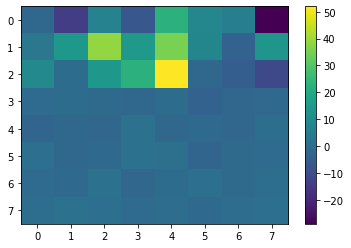

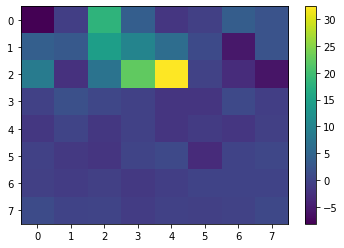

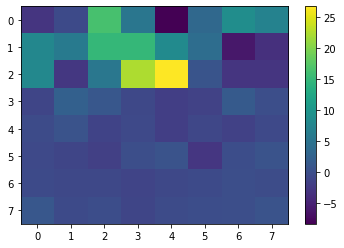

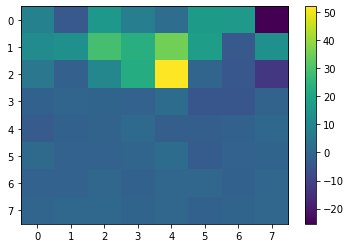

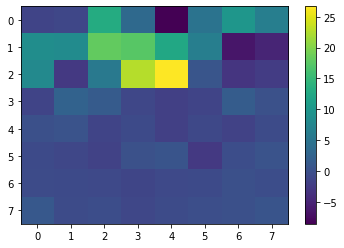

In [29]:
#careful to which input you are choosing!
Input_before_norm = np.loadtxt(open('../MODELS/'+specie+'/partial1/'+str(N)+'/Data/'+"Input_before_norm.csv", "rb"), delimiter=',')
S_test_1 = np.loadtxt(open('../MODELS/'+specie+'/partial1/'+str(N)+'/Data/'+"S_test.csv", "rb"), delimiter=',')
M_test = np.loadtxt(open('../MODELS/'+specie+'/partial1/'+str(N)+'/Data/'+"M_test.csv", "rb"), delimiter=',')
V = np.loadtxt(open('../MODELS/'+specie+'/partial1/'+str(N)+'/Data/'+"V.csv", "rb"), delimiter=',')
                    #version with normalization by paper
ma,mi = max_min(Input_before_norm)
M_train_before_norm = np.loadtxt(open('../MODELS/'+specie+'/partial1/'+str(N)+'/Data/'+"M_train_before_norm.csv", "rb"), delimiter=',')
M_train_before_norm = normalize_M(M_train_before_norm)
M_test = normalize_M_test(M_test,M_train_before_norm[1],M_train_before_norm[2])
#be careful to which normalization you want to use and to the cut
S_1_predicted = predictions(N,DFNN_1,Decoder_1,n_params,S_test_1,M_test,V,ma,mi)

#end of predicitons: after plots and analysis

44365.05534110355 -13382.02097946062


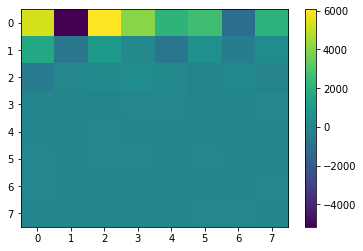

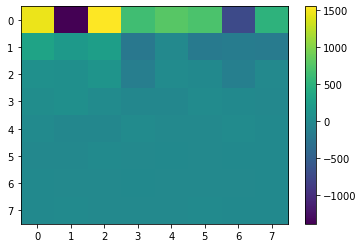

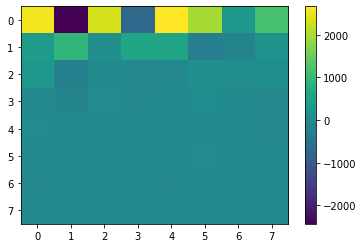

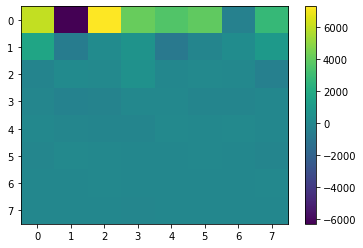

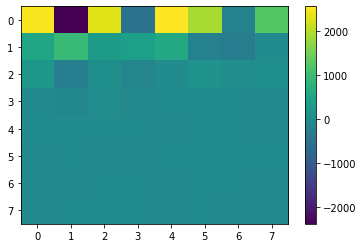

In [30]:
#careful to which input you are choosing!
Input_before_norm = np.loadtxt(open('../MODELS/'+specie+'/partial2/'+str(N)+'/Data/'+"Input_before_norm.csv", "rb"), delimiter=',')
S_test_2 = np.loadtxt(open('../MODELS/'+specie+'/partial2/'+str(N)+'/Data/'+"S_test.csv", "rb"), delimiter=',')
M_test = np.loadtxt(open('../MODELS/'+specie+'/partial2/'+str(N)+'/Data/'+"M_test.csv", "rb"), delimiter=',')
V = np.loadtxt(open('../MODELS/'+specie+'/partial2/'+str(N)+'/Data/'+"V.csv", "rb"), delimiter=',')
                    #version with normalization by paper
ma,mi = max_min(Input_before_norm)
M_train_before_norm = np.loadtxt(open('../MODELS/'+specie+'/partial2/'+str(N)+'/Data/'+"M_train_before_norm.csv", "rb"), delimiter=',')
M_train_before_norm = normalize_M(M_train_before_norm)
M_test = normalize_M_test(M_test,M_train_before_norm[1],M_train_before_norm[2])
#be careful to which normalization you want to use and to the cut
S_2_predicted = predictions(N,DFNN_2,Decoder_2,n_params,S_test_2,M_test,V,ma,mi)

70742.54057665987 -7985.61121466801


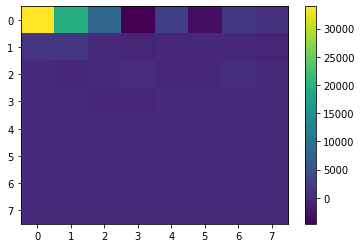

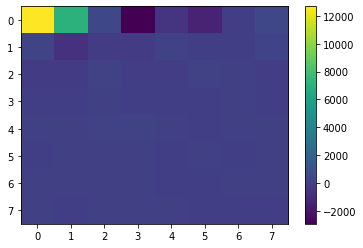

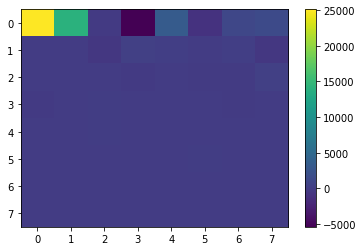

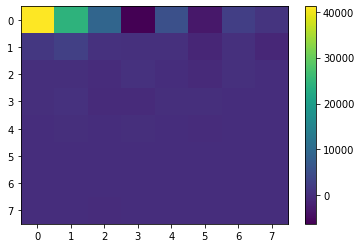

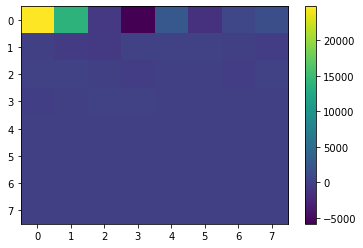

In [31]:
#careful to which input you are choosing!
Input_before_norm = np.loadtxt(open('../MODELS/'+specie+'/partial3/'+str(N)+'/Data/'+"Input_before_norm.csv", "rb"), delimiter=',')
S_test_3 = np.loadtxt(open('../MODELS/'+specie+'/partial3/'+str(N)+'/Data/'+"S_test.csv", "rb"), delimiter=',')
M_test = np.loadtxt(open('../MODELS/'+specie+'/partial3/'+str(N)+'/Data/'+"M_test.csv", "rb"), delimiter=',')
V = np.loadtxt(open('../MODELS/'+specie+'/partial3/'+str(N)+'/Data/'+"V.csv", "rb"), delimiter=',')
                    #version with normalization by paper
ma,mi = max_min(Input_before_norm)
M_train_before_norm = np.loadtxt(open('../MODELS/'+specie+'/partial3/'+str(N)+'/Data/'+"M_train_before_norm.csv", "rb"), delimiter=',')
M_train_before_norm = normalize_M(M_train_before_norm)
M_test = normalize_M_test(M_test,M_train_before_norm[1],M_train_before_norm[2])
#be careful to which normalization you want to use and to the cut
S_3_predicted = predictions(N,DFNN_3,Decoder_3,n_params,S_test_3,M_test,V,ma,mi)

In [32]:
S_predicted = np.zeros((200,68650))
S_test = np.zeros((200,68650))
one = 0
two = 0
three = 0
for i in range(200):
    if(i%40+1)<=12:
        S_predicted[i,:] = S_1_predicted[one,:]
        S_test[i,:] = S_test_1[one,:]
        one+=1
    if(i%40+1)>12 and (i%40+1)<26:
        S_predicted[i,:] = S_2_predicted[two,:]
        S_test[i,:] = S_test_2[two,:]
        two+=1
    if(i%40+1)>25:
        S_predicted[i,:] = S_3_predicted[three,:]
        S_test[i,:] = S_test_3[three,:]
        three+=1
print(one)   
print(two)
print(three)
    

60
65
75


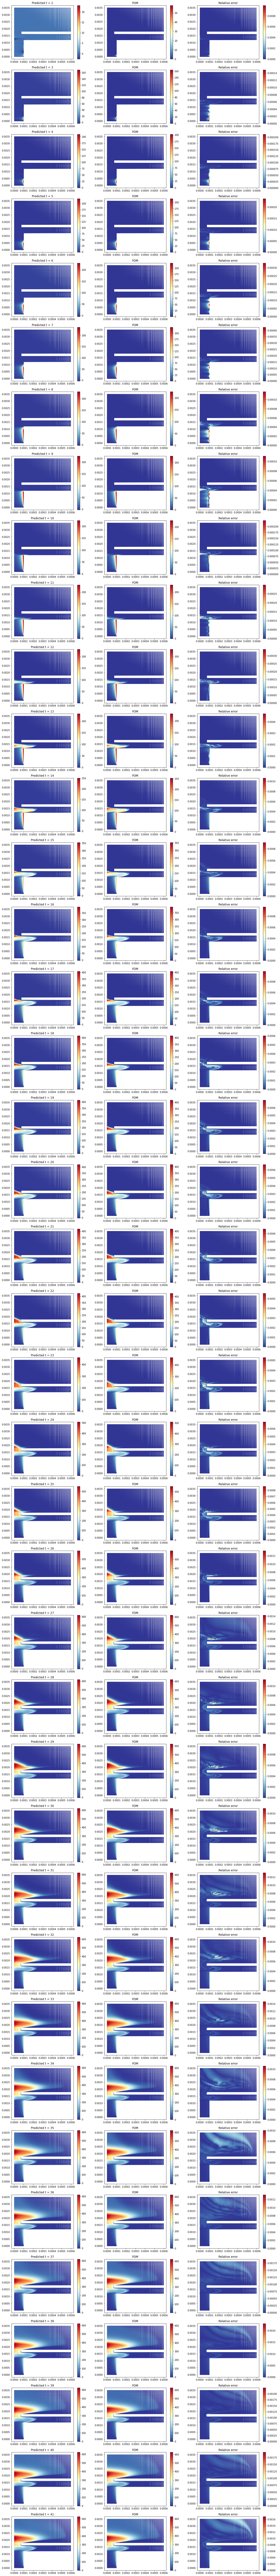

0

In [44]:
#careful to how many snapshot
plots_in_time(S_test,S_predicted,cell_true,path+'/Figures',40,np.arange(2,42,1))



In [ ]:
fig,ax = plt.subplots(1,4,figsize = (15,10))
cm = plt.cm.get_cmap('RdYlBu_r')
#ax = fig.gca(projection='3d')
scatter_plot = ax[0].scatter(cell_true[:,0], cell_true[:,1], c = S_predicted[4,:], lw=0, s=20,cmap=cm)
scatter_plot = ax[1].scatter(cell_true[:,0], cell_true[:,1], c = S_predicted[5,:], lw=0, s=20,cmap=cm)
scatter_plot = ax[2].scatter(cell_true[:,0], cell_true[:,1], c = S_predicted[6,:], lw=0, s=20,cmap=cm)
scatter_plot = ax[3].scatter(cell_true[:,0], cell_true[:,1], c = S_predicted[7,:], lw=0, s=20,cmap=cm)
plt.colorbar(scatter_plot)

In [ ]:
seconds = 80
fig,ax = plt.subplots(80,3,figsize = (20,300))
sec = 1.5
for i in range(80):
    
    count = i
    cm = plt.cm.get_cmap('RdYlBu_r')
    #ax = fig.gca(projection='3d')
    scatter_plot = ax[i][0].scatter(cell_true[:,0], cell_true[:,1], c = S_predicted[count,:], s=1,cmap=cm)
    ax[i][0].set_title('Predicted t = '+str(sec))
    ax[i][0].axis('off')
    plt.colorbar(scatter_plot, ax=ax[i,0])
    scatter_plot = ax[i][1].scatter(cell_true[:,0], cell_true[:,1], c = S_test[count,:], s=1,cmap=cm)
    ax[i][1].set_title('FOM')
    ax[i][1].axis('off')
    plt.colorbar(scatter_plot, ax=ax[i,1])
    scatter_plot = ax[i][2].scatter(cell_true[:,0], cell_true[:,1], c = np.abs(S_test[count,:]-S_predicted[count,:])/np.sqrt(1/seconds*np.sum(np.linalg.norm(S_test[0:seconds],axis=1)**2)), s=1,cmap=cm)
    ax[i][2].set_title('Relative error')
    ax[i][2].axis('off')
    plt.colorbar(scatter_plot, ax=ax[i,2])
    sec += 0.5
plt.savefig(path+'/vWFs_with_41_second_t_final_allsec.png',dpi=150,facecolor='w',transparent=True)
plt.show()

In [ ]:
#error
arr = []
for i in range(40):
    count = i+0
    arr.append(np.mean(np.sum((S_predicted[count,:]-S_test[count,:])**2)**0.5))
    print(np.mean(np.sum((S_predicted[count,:]-S_test[count,:])**2)**0.5))
plt.plot(arr)

In [ ]:
fig,ax = plt.subplots(1,3,figsize = (20,10))
cm = plt.cm.get_cmap('RdYlBu_r')
#ax = fig.gca(projection='3d')
scatter_plot = ax[0].scatter(cell_true[:,0], cell_true[:,1], c = V1[:,0], lw=0, s=20,cmap=cm)
plt.colorbar(scatter_plot, ax=ax[0])
scatter_plot = ax[1].scatter(cell_true[:,0], cell_true[:,1], c = V2[:,0], lw=0, s=20,cmap=cm)
plt.colorbar(scatter_plot, ax=ax[1])
scatter_plot = ax[2].scatter(cell_true[:,0], cell_true[:,1], c = np.abs(S_predicted[20,:]), lw=0, s=20,cmap=cm)
plt.colorbar(scatter_plot, ax=ax[2])


In [ ]:
plt.figure(figsize = (10,10))
plt.plot(S_test[0,:],label='0')
#plt.plot(S_test[65,:],label='40')
#plt.plot(((S_predicted[0,:])-np.array(S_test[0,:]))**2,label='Diff')
plt.legend()

In [ ]:
first = plot_re_err(S_test,S_predicted,15,path,N)# 0.03238622082843075

In [ ]:
plots_in_sim_interpolated(S_test,S_predicted,cell_true,path+'/Figures',41,40)

In [ ]:
sec = plot_re_err(S_test,S_predicted,13,path,N)

In [ ]:
fig,ax = plt.subplots(figsize = (20,10))
ax.plot(np.arange(2,42,1),sec,'o',label = r'$N = 64,$ full interval, $ \epsilon_G = 0.0324 $')
ax.set_yscale('log')
ax.set_xlabel('Second',fontsize=15)
ax.set_ylabel('Relative error per second',fontsize=15)
ax.set_xlim([0,42])
ax.set_title('Relative error per second',fontsize=20)
ax.plot(np.arange(2,42,1),first,'o',label = r'$N = 64,$ two intervals, $ \epsilon_G = 0.0337 $',color = 'r')
ax.set_ylim([0,30])
plt.vlines(5.5,0,30,colors = 'r',linestyles='dashed')
plt.legend(fontsize=14)
plt.savefig(path+'relative_error_64_fulldouble.png',dpi=200,facecolor='w',transparent=True,bbox_inches='tight')

Relative error on all time is 0.018481360722699836


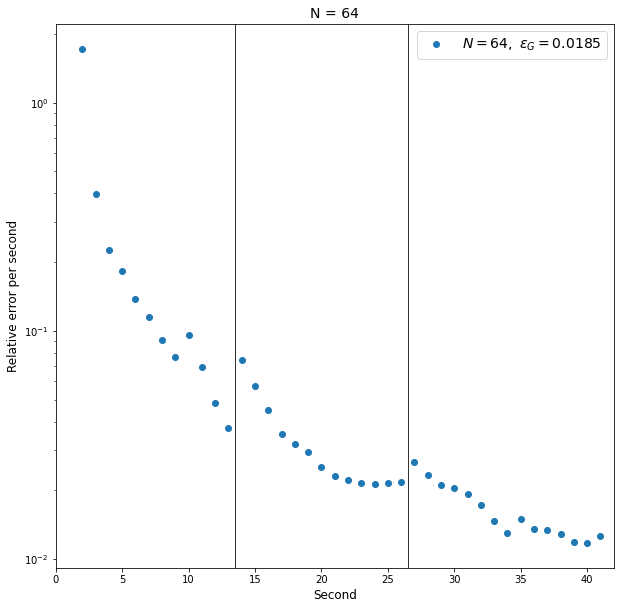

In [43]:
third = plot_re_err(S_test,S_predicted,40,path,N)

In [ ]:
fig,ax = plt.subplots(figsize = (20,10))
ax.plot(np.arange(2,42,1),first,'o', label= r'$N = 64,$ $ \epsilon_G = 0.0323 $',markersize = 3)
ax.set_yscale('log')
ax.set_xlabel('Second',fontsize=15)
ax.set_ylabel('Relative error per second',fontsize=15)
ax.set_xlim([0,42])
ax.set_title('Relative error per second',fontsize=20)
ax.plot(np.arange(2,42,1),sec,'o', label =  r'$N = 256,$ $ \epsilon_G = 0.0364 $',markersize = 3)
ax.plot(np.arange(2,42,1),third,'o', label =  r'$N = 1024,$ $ \epsilon_G = 0.3663 $',markersize = 3)
plt.legend(fontsize=14)
plt.savefig('relative_error_64_256_1024.png',dpi=200,facecolor='w',transparent=True,bbox_inches='tight')

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(np.array(sec)[-23:]-np.array(first)[-23:],'*')
#plt.yscale('log')
plt.xlabel('Seconds')
plt.ylabel('Difference relative error N = 64  and N = 256')

In [ ]:
r = np.loadtxt(open(home+'/Data/'+"M_trainV.csv", "rb"), delimiter=',')

In [ ]:
def normalize_S(S):
    S_max = np.amax(S)
    S_min = -np.amax(-S)
    print(S_max)
    print(S_min)
    return (S-S_min)/(S_max-S_min)
S = normalize_S(Input_before_norm)

In [ ]:
I = np.zeros((200,6))
for count,i in enumerate(S[0:200]):
    inp_enc = tf.reshape(i,[-1,int(np.sqrt(N)),int(np.sqrt(N)),1])
    I[count,:] = Encoder(inp_enc)

In [ ]:
fig,ax = plt.subplots(10,4,figsize = (20,40))
for i in range(10):
    count = (4*i)+0
    scatter_plot = ax[i][0].plot(I[count],'*')
    ax[i][0].set_title('t = '+ str(count+2))
    scatter_plot = ax[i][1].plot(I[count+1],'*')
    ax[i][1].set_title('t = '+ str(count+2+1))
    scatter_plot = ax[i][2].plot(I[count+2],'*')
    ax[i][2].set_title('t = '+ str(count+2+2))
    scatter_plot = ax[i][3].plot(I[count+3],'*')
    ax[i][3].set_title('t = '+ str(count+2+3))

plt.savefig('out_enc2.png',dpi = 200,facecolor='w',transparent=True)

In [ ]:
print(I[0])
print(I[40])
print(I[160])

In [ ]:
print(5e-3)